# Top Universities for International Students
# About the Project

This project is an informative analysis of universities around the world, tailored specifically for international students seeking useful insights and recommendations. Additionally, this project identifies potential problems in universities, which will be further investigated in future analyses with more relevant data and potential solutions.

There are several questions that this project will attempt to answer:
1. Which universities are most popular with international students?
    - What can we learn about the student-per-staff ratios at these universities? Are there any universities where there are a lot more students than staff, or vice versa?
    - Are there any universities that are a more popular choice for a particular gender?
2. What does the student-per-staff ratio mean and how can it affect students, staff, and universities?
    - Are there any universities with a concerning student-per-staff ratios?

# Environment and Data Preparation
Before we go into the exploratory analysis process, let's prepare the dataset and libraries required.

In [1]:
!pip install country_converter --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import country_converter as coco

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv("/kaggle/input/global-university-rankings-dataset-2023/world_university_rank.csv")

In [4]:
# Checking the dataset contents
df.head(2)

,Rank,University name,locationLocation,Number of Studnet,Number of student per staffs,International Student,Female : male ratio
0,1,University of Oxford,United Kingdom,"20,965",10.6,42%,48 : 52
1,2,Harvard University,United States,"21,887",9.6,25%,50 : 50


In [5]:
# Checking the dataset condition (Data type and missing values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Rank                          2345 non-null   object 
 1   University name               2345 non-null   object 
 2   locationLocation              2234 non-null   object 
 3   Number of Studnet             2345 non-null   object 
 4   Number of student per staffs  2344 non-null   float64
 5   International Student         2345 non-null   object 
 6   Female : male ratio           2255 non-null   object 
dtypes: float64(1), object(6)
memory usage: 128.4+ KB


Here are some changes we can make to the data to improve its analysis:

1. Convert all column names to snake case, which is a style of writing names that uses underscores instead of spaces or hyphens. This will make the names easier to read and write.
2. Convert the `International Student` column to a numerical value. This will allow us to perform more detailed analysis on this data.
3. Separate the `Female : male ratio` column into two columns: `female_ratio` and `male_ratio`. This will give us more detailed information about the gender distribution at each university.

## Data Cleaning, Manipulation, and Transformation

*Disclaimer: We will not remove nor impute missing values for the following analysis project, unless there's a need for modelling*

Firstly, let's check the missing values frequency in the data.

In [6]:
# Checking for missing values
df.isnull().sum()

Rank                              0
University name                   0
locationLocation                111
Number of Studnet                 0
Number of student per staffs      1
International Student             0
Female : male ratio              90
dtype: int64

Most missing values do come from University's locations and the female-to-male ratio, several potential causes including:
1. **University locations:** It can be difficult to collect accurate data on university locations, especially for universities that are located in remote areas or that have multiple campuses.
2. **Female-to-male ratio:** The female-to-male ratio is another data point that can be difficult to collect accurately. This is because it is often based on self-reported data, and people may not always be truthful about their gender.

Then, let's check for duplicated data.

In [7]:
# Checking for duplicates
df.duplicated().sum()

0

There are no duplicates in the dataset. Next, we are going to clean all column names, fixing the typos and adding an underscore if there is a space between words.

In [8]:
# Cleaning all column names
col_names = df.columns.tolist()
clean_names = []

for i in col_names:
    col = i.replace(':', ' ').lower().replace(' ', '_')
    clean_names.append(col)

# Manually changing several name with typos
clean_names[2:5] = ['location', 'n_student', 'n_student_per_staff'] 
clean_names[-2:] = ['international_student_prop', 'female_male_ratio']

# Applying the changes
df.columns = clean_names
df.sample(2)

,rank,university_name,location,n_student,n_student_per_staff,international_student_prop,female_male_ratio
1780,1501+,Universiti Malaysia Sabah (UMS),Malaysia,"17,068",19.0,4%,67 : 33
1646,1501+,Latvia University of Life Sciences and Technol...,Latvia,"3,891",24.9,4%,52 : 48


Additionally, we need to convert `international_student_prop` to float. But it has a special character (percent symbol) that we need to clean first before the conversion process.

In [9]:
# Removing '%' from `international_students`
val = []

for a, b in df.iterrows():
    val.append(b['international_student_prop'].replace('%', ''))

df['international_student_prop'] = val

# Making sure that empty values are encoded NaN (In this case, if the original value is only the "%" sign)
df['international_student_prop'].replace('', None, inplace = True)

# Changing the data type from object to float
df['international_student_prop'] = df['international_student_prop'].astype('float64')

We then extract a new variables from the `female_male_ratio`, namely: `female_prop` and `male_prop` and drop the `female_male_ratio` one.

In [10]:
# Dividing `female_male_ratio` to separate columns: `female_prop` and `male_prop`
divided = df['female_male_ratio'].str.split(':', expand = True).astype('float64')
divided.rename(columns = {0:'female_prop', 1:'male_prop'}, inplace = True)

# Joining the `female_prop` and `male_prop` to original df
df = df.join(divided)

# Dropping the `female_male_ratio` column
df.drop(columns = 'female_male_ratio', inplace = True)

Then, we need to change the `n_student` variable to an integer.

In [11]:
# Changing `n_student` from object to integer
df['n_student'] = df['n_student'].str.replace(',', '').astype('int')

Let's see the final changes.

In [12]:
# Seeing the new data
df.sample(2)

,rank,university_name,location,n_student,n_student_per_staff,international_student_prop,female_prop,male_prop
1115,1001–1200,University of Murcia,Spain,26351,16.0,8.0,59.0,41.0
319,301–350,George Mason University,United States,32157,18.1,12.0,53.0,47.0


# Initial Exploration (EDA)

## Summary Statistics

In [13]:
# Numerical Summary Statistics
df.describe()

,n_student,n_student_per_staff,international_student_prop,female_prop,male_prop
count,2345.000000,2344.000000,2342.000000,2255.00000,2255.00000
mean,19220.701066,18.722056,10.295901,50.84878,49.15122
std,24575.292996,11.921330,13.205858,13.70418,13.70418
min,115.000000,0.400000,0.000000,2.00000,0.00000
25%,6988.000000,12.300000,1.000000,43.00000,41.00000
50%,13956.000000,16.300000,5.000000,53.00000,47.00000
75%,25215.000000,21.900000,14.000000,59.00000,57.00000
max,460632.000000,232.200000,100.000000,100.00000,98.00000


Here are some interesting insights from the data:
1. **Number of Students:** The average number of students per university is 19,220.7. However, the median number of students is lower, at 13,956. This means that, on average, each university has about around 13,956 students and this tells us that there are a few universities with a very high number of students, which is pulling up the average.
2. **Student-per-Staff:** On average, each academic staff member is responsible for teaching and supporting approximately 16 students. This means that, on average, each academic staff member has about 16 students to teach and support. A lower ratio may suggest better student-to-faculty interaction and potentially improved educational experiences, as students may have more opportunities to engage with faculty members.
3. **International Student Proportion:** The mean proportion of international students is 10%, higher than its median of 5%. This means that, on average, 5% of the students at each university are international students. However, several universities in our dataset have a higher proportion of international students.
4. **Gender Imbalance:** There is a modest gender imbalance, with a slightly higher proportion of female students, on average. This means that, on average, there are slightly more female students than male students at universities. However, the difference is not very large.

In [14]:
# Categorical Summary Statistics
df.describe(include = 'object')

,rank,university_name,location
count,2345,2345,2234
unique,161,2345,117
top,Reporter,University of Oxford,United States
freq,546,1,179


1. **Location with the Most Universities** As of 2023, most of the universities are located in the United States, with around 179 university. United States provides a wider choice for study destinations than other countries.
2. **'Reporter' Rank:** Around 23% university listed in the dataset have 'reporter' status that means the university is yet to be ranked (potential analysis branch)

## Univariate Analysis

This section will attempt to inspect the distribution of each variable the data has. First, let's see the distribution of all numeric variables using a box plot.

In [15]:
# Creating the numericals and categoricals variable that contains the column names
nums = df.select_dtypes(exclude = 'object').columns.tolist()
cats = df.select_dtypes(include = 'object').columns.tolist()

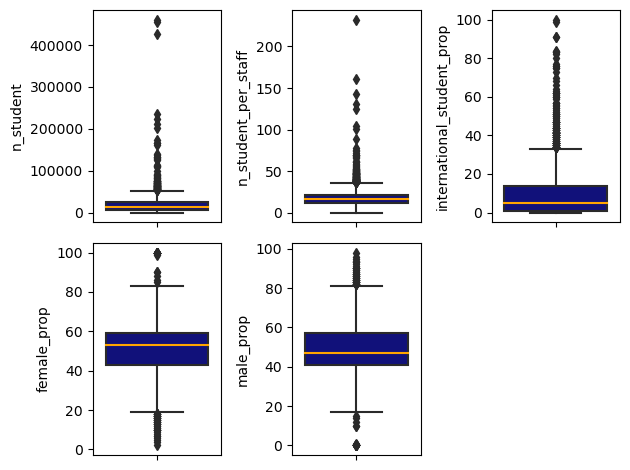

In [16]:
# Boxplot
for i in range(0, len(nums)):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data = df, y = nums[i], color = 'darkblue', medianprops = dict(color = 'orange'))

plt.tight_layout()

As we can see above:
1. **High Number of Students:** Several universities in our dataset have an exceptionally high number of students, with some having over 400,000 students.
2. **Overworked Staff:** A few universities have a high student-per-staff ratio, with one university having more than 200 students per staff member. This suggests that these universities may have overworked staff and that the quality of education may be compromised.
3. **Gender Imbalance:** A subset of universities has a remarkably high proportion of either male or female students, with some institutions having over 80% representation of one gender. This may indicate that these universities are not as inclusive as others.

Then, let's further check the distribution shape using a histogram and their skewness values.

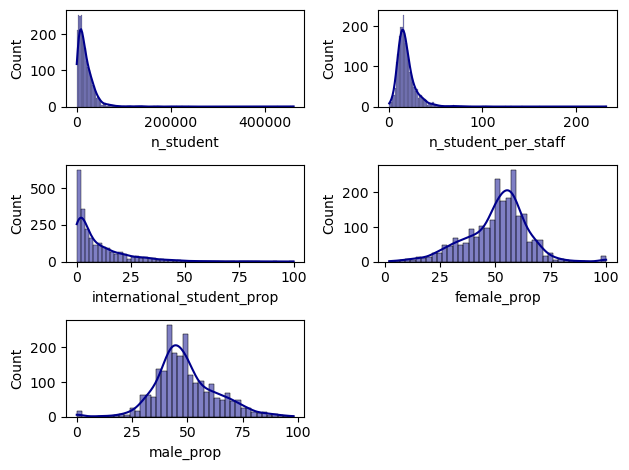

In [17]:
# Histogram + KDE
for i in range(0, len(nums)):
    plt.subplot(3, 2, i + 1)
    sns.histplot(data = df, x = nums[i], kde = True, color = 'darkblue')

plt.tight_layout()

In [18]:
# Skewness in numbers
print('Skewness values:')
df.skew(numeric_only = True)

Skewness values:


n_student                     8.692247
n_student_per_staff           5.496184
international_student_prop    2.319752
female_prop                  -0.289350
male_prop                     0.289350
dtype: float64

Technical notes:
1. Right-skewed distributions: `n_student`, `n_student_per_staff`, and `international_student_prop`
2. Approximately normal distributions: `female_prop` and `male_prop`

The only categorical variable that is insightful to inspect on by itself is `location`. But it has 117 unique values and the resulting plot will not be readable (it would be too cluttered). There are three possible approaches for this, either:
1. Get the continent for each location and aggregate by the continent
2. Get the top location with most universities
3. Plotting using a world map

For this analysis, let's take the second approach (because we don't have the continent data) where we'll take a look at the top 10 location with the most universities as this will give us a better understanding of the most popular locations for universities.

We'll take the third approach later on.

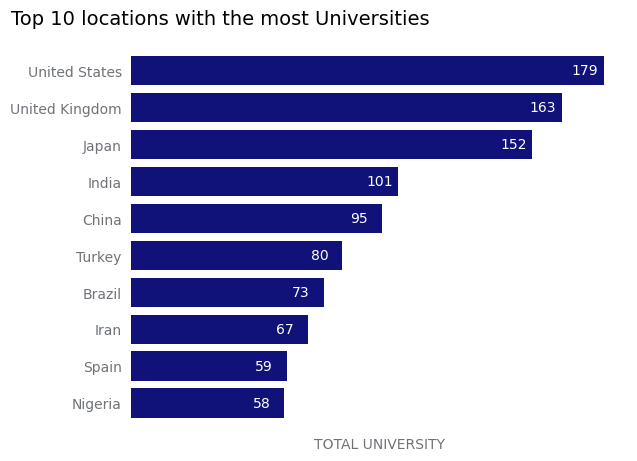

In [19]:
# Finding the top 10 countries with most universities
top_10_loc = df['location'].value_counts().reset_index().head(10)
top_10_loc.columns = ['country', 'count']

# Countplot: Top 10 countries with most universities
ax = sns.barplot(data = top_10_loc, y = 'country', x = 'count', color = 'darkblue')
sns.despine(right = True, bottom = True, left = True)

# Adding bar labels to each bar
barlab = ax.bar_label(ax.containers[0], label_type = 'edge', color = 'white', padding = -23)

ax.set_xticklabels([]) 
ax.tick_params(left = False, bottom = False)

    
ax.set_yticklabels(ax.get_yticklabels(), color = '#6F7378')
ax.set_ylabel('')
ax.set_xlabel('TOTAL UNIVERSITY', color = '#6F7378')
ax.set_title('Top 10 locations with the most Universities', pad = 20, x = 0.18, size = 14)

plt.show()

Insight:
- According to the dataset, The United States, United Kingdom, and Japan have the most universities in the dataset. This suggests that these countries place a high value on education and that they offer a wide variety of educational opportunities for students.

But what about the typical student size across these popular locations? Let's find out quickly using the median instead of mean because we know that the `n_student` variable is right-skewed.

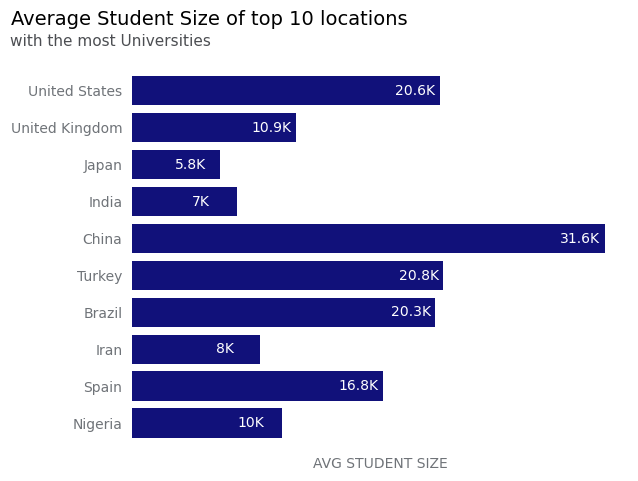

In [20]:
# Aggregating the median by the top 10 location
top_loc_list = top_10_loc['country'].tolist()
top_loc_student_size = df[df['location'].isin(top_loc_list)].groupby('location', as_index = False)[['n_student']].median()

# Bar plot
fig, ax = plt.subplots()
sns.barplot(x = 'n_student', y = 'location', data = top_loc_student_size, order = top_loc_list, 
            color = 'darkblue', ax = ax)
sns.despine(right = True, bottom = True, left = True)

ax.bar_label(ax.containers[0], labels = ['20.6K', '10.9K', '5.8K', '7K', '31.6K', 
                                         '20.8K', '20.3K', '8K', '16.8K', '10K'],
             padding = -32, color = 'white', fmt = '%.0f')
ax.set_xticklabels([]) 
ax.tick_params(left = False, bottom = False)
    
ax.set_ylabel('')
ax.set_yticklabels(ax.get_yticklabels(), color = '#6F7378')
ax.set_xlabel('AVG STUDENT SIZE', color = '#6F7378')
ax.set_title('Average Student Size of top 10 locations', pad = 34, x = 0.155, size = 14)
ax.text(s = 'with the most Universities', color = '#4C4E52', x = -8200, y = -1.2, size = 11)

plt.show()

*Note: This bar plot is not ordered ascendingly/descendingly to preserve the university count ranking from the previous bar plot.*

Insights:

- Overall, several universities have a small median student size (less than approx. 10,000 students per university), while others have more than 15,000 students per university, with China having the highest median student size (31,600 students per university).

- Japan has more universities than any of the countries below it, but it also has the smallest average student enrollment (around 5,800 students per university). This suggests that Japanese universities tend to be smaller and more specialized.

- China has the largest average student enrollment (around 31,600 students per university), but it has fewer universities than the United States, the United Kingdom, Japan, and India (95 universities). This suggests that Chinese universities tend to be larger and more comprehensive than universities in other countries. This is consistent with the Chinese education system, which emphasizes mass education and the development of a highly skilled workforce.

Next, to better see the distribution of universities across **all countries**, let's visualize them in a choropleth map. 

In [21]:
# Getting the ISO3 country code
import country_converter as coco

iso3_countries = []
for i in df['location']:
    try:
        iso3_countries.append(coco.convert(i, to = 'ISO3'))
    except:
        iso3_countries.append(None)

# Adding the ISO3 location back to the dataset
df['location_iso3'] = iso3_countries

# Aggregating the dataset to find the count of universities from each country
world_uni_loc = df.groupby(['location', 'location_iso3'])[['university_name']].count().reset_index()
world_uni_loc.rename(columns = {'university_name':'university_count'}, inplace = True)

In [22]:
# Visualizing the choropleth
import plotly.express as px

fig = px.choropleth(world_uni_loc, locations="location_iso3",
                    color="university_count",
                    hover_name="location",
                    color_continuous_scale='aggrnyl',
                    title = 'University Distributions Across the World',
                    labels={'university_count':'Total University'})

fig.show()

We can confirm further that USA, United Kingdom, and Japan has the most universities according to this dataset. There are several countries with a rising number of universities like India, China, and Turkey.  

# Question 1: What are the top universities for international students?

First, let's explore the locations of popular universities for international students. For the purpose of this exploration, we will assume that universities with a population of more than 50% international students are considered popular universities for international students.

In [23]:
# Aggregating the count of total popular university across locations
int_uni_loc = df[df['international_student_prop'] >= 50].groupby(['location', 'location_iso3'])[['university_name']].count()\
              .reset_index().rename(columns = {'university_name':'university_count'})

In [24]:
# Plotting the choropleth map
fig = px.choropleth(int_uni_loc, locations = 'location_iso3',
                    color = 'university_count',
                    hover_name = 'location',
                    color_continuous_scale = 'aggrnyl',
                    title = 'Popular University for International Students Distribution Across the World',
                    labels = {'university_count':'Total University'})

fig.show()

The choropleth map above shows that the United Kingdom is the most popular country for international students, with the most popular universities.

Let's see the top 10 universities for international students based on the international student proportion

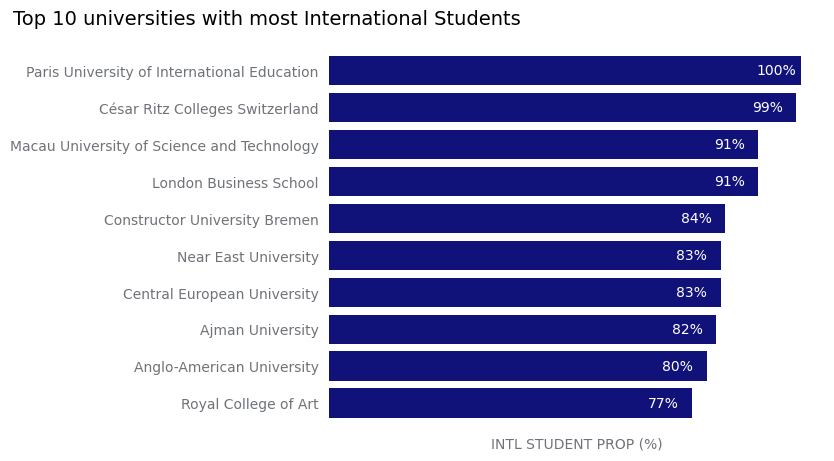

In [25]:
# Getting the top 10 uni with most international students
top_10_int_uni = df.nlargest(10, 'international_student_prop')

# Countplot: Top 10 countries with most universities
ax = sns.barplot(data = top_10_int_uni, y = 'university_name', x = 'international_student_prop', color = 'darkblue')
sns.despine(right = True, bottom = True, left = True)

# Adding bar labels to each bar
barlab = ax.bar_label(ax.containers[0], label_type = 'edge', color = 'white', padding = -32, fmt = '%.f%%')


ax.tick_params(left = False, bottom = False)
    
ax.set_ylabel('')
ax.set_yticklabels(ax.get_yticklabels(), color = '#6F7378')
ax.set_xlabel('INTL STUDENT PROP (%)', color = '#6F7378')
ax.set_xticklabels([]) 
ax.set_title('Top 10 universities with most International Students', pad = 20, x = -0.125, size = 14)


plt.show()

The plot above shows that several universities have an extremely high proportion of international students, with Paris University of International Education having 100% international students, meaning that this specific university is only for international students.

Next, we need to explore the typical rank of these top 10 universities.

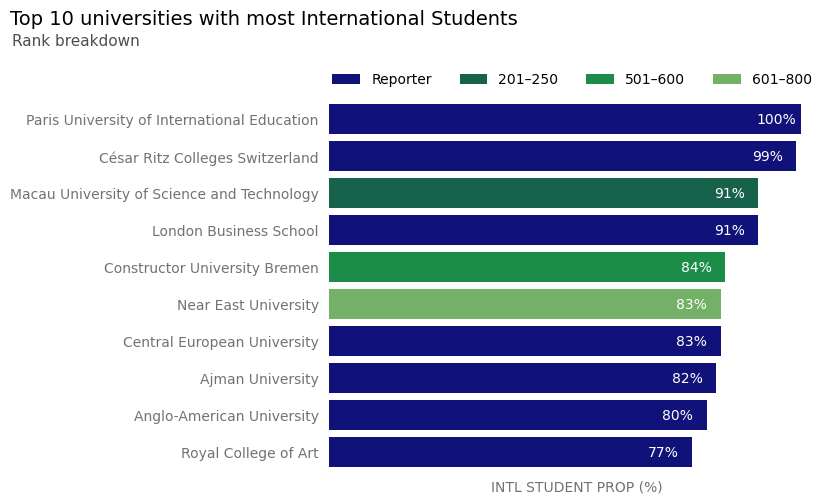

In [26]:
# Countplot: Top 10 countries with most universities
palette = {'Reporter' : 'darkblue', 
           '201–250' : '#0B6E4F', 
           '501–600' : '#08A045',
           '601–800' : '#6BBF59'}

fig, ax = plt.subplots()
sns.barplot(data = top_10_int_uni, y = 'university_name', x = 'international_student_prop', 
            hue = 'rank', palette = palette, dodge = False, ax = ax)
sns.despine(right = True, bottom = True, left = True)

# Adding bar labels to each bar
for i in range (len(ax.containers)):
    barlab = ax.bar_label(ax.containers[i], label_type = 'edge', color = 'white', padding = -32, fmt = '%.f%%')

ax.tick_params(left = False, bottom = False, labelbottom = False)
    
ax.set_ylabel('')
ax.set_yticklabels(ax.get_yticklabels(), color = '#6F7378')
ax.set_xlabel('INTL STUDENT PROP (%)', color = '#6F7378', labelpad = 7)
ax.set_title('Top 10 universities with most International Students', size = 14, pad = 55, x = -0.13)
ax.text(s = 'Rank breakdown', color = '#4C4E52', x = -67, y = -2, size = 11)

ax.legend(ncols = 4, bbox_to_anchor = (1, 1.11), loc="upper right", frameon = False)

plt.show()

The majority of these top 10 universities with a large international student population have a reporter rank, meaning that they have not yet been officially ranked. Only three universities with a large international student population are ranked in the 201-250th, 501-600th, and 601-800th. This suggests that many universities with a high proportion of international students are not yet recognized for their excellence.

Next, let's investigate whether these top 10 popular universities for international students have more students per staff (indicating overworked staff), a balanced ratio, or more staff per student.

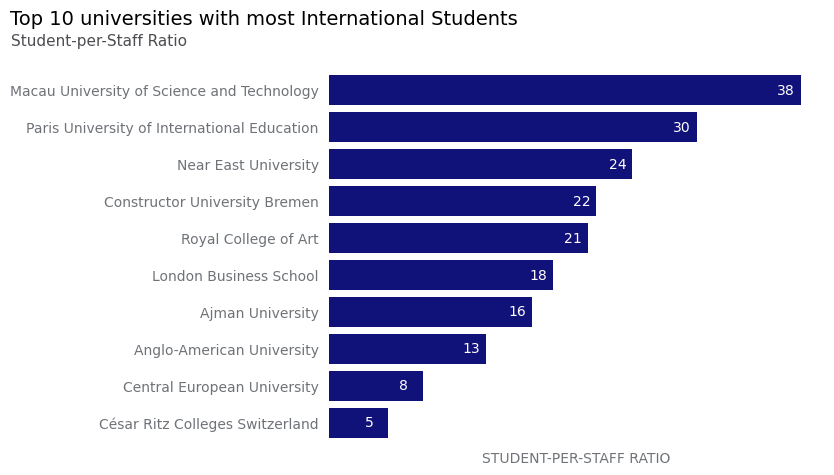

In [27]:
# Sort descending by student to staff ratio
top_10_int_uni.sort_values('n_student_per_staff', ascending = False, inplace = True)

# Visualizing university vs. student to staff ratio
fig, ax = plt.subplots()
sns.barplot(ax = ax, y = 'university_name', x = 'n_student_per_staff', data = top_10_int_uni,
            color = 'darkblue')
sns.despine(right = True, bottom = True, left = True)

# Adding bar labels to each bar
barlab = ax.bar_label(ax.containers[0], label_type = 'edge', color = 'white', padding = -17, fmt = '%.0f')

ax.tick_params(left = False, bottom = False, labelbottom = False)
ax.set_xlabel('STUDENT-PER-STAFF RATIO', color = '#6F7378', labelpad = 7)
ax.set_ylabel('')
ax.set_yticklabels(ax.get_yticklabels(), color = '#6F7378')
ax.set_title('Top 10 universities with most International Students', pad = 34, x = -0.13, size = 14)
ax.text(s = 'Student-per-Staff Ratio', color = '#4C4E52', x = -25.65, y = -1.2, size = 11)

plt.show()

The student-per-staff ratio among these top 10 universities for international students varies moderately, with some having very low ratios and others having moderate ratios.

César Ritz Colleges Switzerland and Central European University have particularly low student-per-staff ratios, suggesting that they provide more personalized attention to their students.

Finally, let's examine the gender distribution of these universities. A low proportion of female students indicates that the university is more popular with male students, and vice versa.

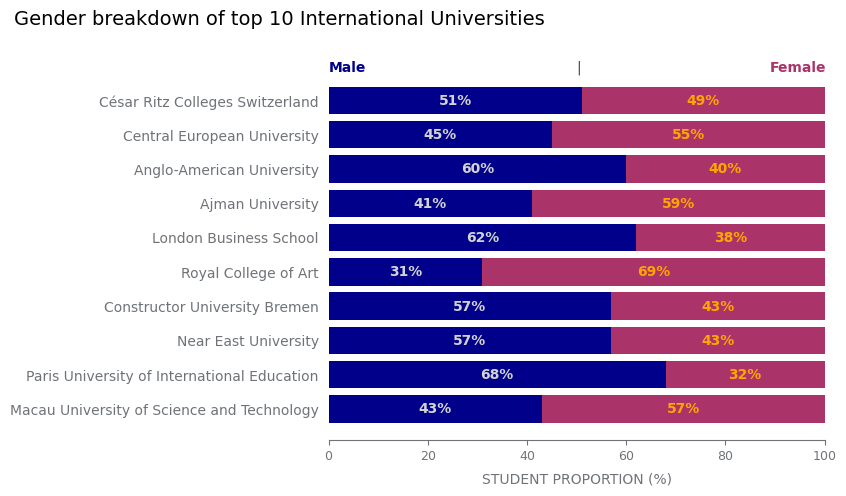

In [28]:
fig, ax = plt.subplots()

ax.barh(data = top_10_int_uni, width = 'male_prop', y = 'university_name', color = 'darkblue', label = 'Male')
ax.barh(data = top_10_int_uni, width = 'female_prop', y = 'university_name', left = 'male_prop', color = '#AA336A', label = 'Female')
sns.despine(right = True, left = True)
ax.tick_params(left = False, color = '#6F7378')
ax.set_xlim(0, 100)
ax.set_xlabel('STUDENT PROPORTION (%)', color = '#6F7378', labelpad = 7)

plt.setp(ax.get_xticklabels(), color = "#6F7378", size = 9)
plt.setp(ax.get_yticklabels(), color = "#6F7378")
for spine in ax.spines.values():
    spine.set_edgecolor("#6F7378")

ax.bar_label(ax.containers[0], label_type='center', color = 'lightgray', fmt='%.0f%%', weight = 'bold')
ax.bar_label(ax.containers[1], label_type='center', color = 'orange', fmt='%.0f%%', weight = 'bold')    

ax.set_title('Gender breakdown of top 10 International Universities', x = -0.1, y = 1.1, fontsize = 14)
ax.text(s = 'Male', y = 9.85, x = 0, color = 'darkblue', weight = 'bold')
ax.text(s = '|', y = 9.85, x = 50, color = '#404040')
ax.text(s = 'Female', y = 9.85, x = 89, color = '#AA336A', weight = 'bold')
plt.show()

Almost all of the top 10 international universities in the figure above are more popular with males or females, except for César Ritz Colleges Switzerland, where the proportion of male and female students is nearly balanced, although slightly male-dominated.

This suggests that universities more popular with a particular gender may be preferred by students of that gender. Based on this finding, here are some universities that are more popular with male students:

1. Anglo-American University
2. London Business School
3. Constructor University Bremen
4. Near East University
5. Paris University of International Education

And here are some universities that are more popular with female students:

1. Central European University
2. Ajman University
3. Royal College of Art
4. Macau University of Science and Technology

These universities are more popular with male or female students, but this does not mean that they admit more students of one gender than the other. The probability of being admitted to any of these universities still depends on academic performance, test scores, language proficiency, and other factors.

## International Universities with Decent Ranks 

Some of you may be interested in studying at highly ranked universities that also accept a large number of international students. Let's filter the data to show universities with numeric ranks and more than 50% international students and inspect them.

In [29]:
int_uni_ranked = df[(df['rank'] != 'Reporter') & (df['international_student_prop'] > 50.0)]
display(int_uni_ranked)

,rank,university_name,location,n_student,n_student_per_staff,international_student_prop,female_prop,male_prop,location_iso3
9,10,Imperial College London,United Kingdom,18545,11.2,61.0,40.0,60.0,GBR
21,22,UCL,United Kingdom,36790,10.3,60.0,59.0,41.0,GBR
34,35,King’s College London,United Kingdom,28965,11.8,52.0,63.0,37.0,GBR
36,37,London School of Economics and Political Science,United Kingdom,11120,11.9,73.0,55.0,45.0,GBR
40,41,École Polytechnique Fédérale de Lausanne,Switzerland,11641,12.3,62.0,30.0,70.0,CHE
61,62,Australian National University,Australia,16758,14.6,51.0,52.0,48.0,AUS
98,99,City University of Hong Kong,Hong Kong,9099,12.1,62.0,54.0,46.0,HKG
144,145,Maastricht University,Netherlands,19909,18.6,56.0,60.0,40.0,NLD
217,201–250,University of Luxembourg,Luxembourg,5185,19.3,51.0,53.0,47.0,LUX
219,201–250,Macau University of Science and Technology,Macao,11993,38.1,91.0,57.0,43.0,MAC


There are a total of 24 'ranked' universities with more than 50% proportion of international students. For visualization purposes, let's inspect the top 10 of these universities based on their ranks.

In [30]:
fig = px.bar(int_uni_ranked.head(10).sort_index(ascending = False), x = 'international_student_prop', y = 'university_name',
             color = 'university_name', 
             color_discrete_map = {'Imperial College London' : '#009c1a',
                                   'UCL' : '#009c1a',
                                   'King’s College London' : '#009c1a',
                                   'London School of Economics and Political Science' : '#009c1a',
                                   'École Polytechnique Fédérale de Lausanne' : '#009c1a', 
                                   'Australian National University' : '#26cc00',
                                   'City University of Hong Kong' : '#26cc00',
                                   'Maastricht University' : '#7be382',
                                   'University of Luxembourg' : '#7be382',
                                   'Macau University of Science and Technology' : '#7be382'},
             hover_data = {'university_name' : False, 'rank' : True, 'n_student_per_staff' : True},
             labels = {'university_name' : '', 
                       'international_student_prop' : 'INTL STUDENT PROP (%)'})

fig.add_shape(type = 'line',
              x0 = 95, y0 = -0.4,
              x1 = 95, y1 = 4.3,
              line = dict(color = '#009c1a'))
fig.add_shape(type = 'line',
              x0 = 95, y0 = 4.6,
              x1 = 95, y1 = 6.3,
              line = dict(color = '#26cc00'))
fig.add_shape(type = 'line',
              x0 = 95, y0 = 6.6,
              x1 = 95, y1 = 9.4,
              line = dict(color = '#7be382'))

fig.add_annotation(showarrow = False, text = '10-41st<br>rank', align = 'left', x = 103.5, y = 1.8,
                   font = dict(color = '#009c1a'))
fig.add_annotation(showarrow = False, text = '62-99th<br>rank', align = 'left', x = 103.5, y = 5.4,
                   font = dict(color = '#26cc00'))
fig.add_annotation(showarrow = False, text = '145-250th<br>rank', align = 'left', x = 105.5, y = 8,
                   font = dict(color = '#7be382'))

fig.update_yaxes(autorange = 'reversed', tickfont = dict(color = '#6F7378'))
fig.update_xaxes(title_font = dict(color = '#6F7378', size = 13), tickfont = dict(color = '#6F7378'), title_standoff = 25)
fig.update_layout(showlegend = False, plot_bgcolor='rgba(0,0,0,0)', margin_pad = 5,
                  title = dict(text = '<b>Top ranked universities popular with International Students</b>',
                               font = dict(size = 20), x = 0.041))

fig.show()

*Note: You can see the exact rank of each university by hovering over each bar.*

Several high-ranked universities are popular with international students, with 50% of them ranked in the 10th to 41st bracket. Macau University of Science and Technology stands out with a high proportion of international students, with 91% of its students coming from outside of Macau. This suggests that Macau University of Science and Technology is a popular choice for international students and may focus its target segmentation more on international students.

If you are interested in studying abroad at a highly ranked university, these hand-picked universities may be a good fit for you. They may offer special programs or packages for international students. 

# Question 2: What about these universities that have more students than staff (and vice versa)?

A good university will provide its students with the best learning experience and a balanced workload for its staff. However, when there are more students than staff, it can lead to several problems, despite the potential for lower overhead costs and increased revenue:

- Students may not receive the best learning support. This is because staff may not be able to effectively manage each student in the class. A common phenomenon is that staff may prioritize students who are perceived as being gifted or active, while neglecting other students. This can lead to students feeling unsupported and having to rely on their own individual efforts to succeed.
- Overworked and stressed staff may burn out, which can negatively impact their teaching performance. For example, they may perform poorly or even miss class altogether, especially if they have other important commitments.

But what if there are more staffs than students? Does it mean that it's better? Let's first discuss the better aspects:

- Students will receive more learning support. This will make the classroom more personalized and students may request for support at any time, whether inside the classroom or outside.
- Staffs will be more aware to their students condition and can quickly spot and treat students with educational problems (for example, declining grades). This will make the student aware of their educational conditions and be guided for improvements until graduation phase.

Then, there are several assumptions regarding the downside of this condition:

- The overhead cost for staff resources will be higher. This may be mitigated by increasing the admission/tuition fees but will only attract future students with a more stable/higher income (unless there's a scholarship program, but this will only capture a handful size of students)
- Universities may struggle to allocate staff resources effectively. There may be excess staff members that may result in underutilized resources and may lead to increased overhead costs.

Beware, though. According to the article ["Learn What the Student to Faculty Ratio Means (and What It Doesn't)"](https://www.thoughtco.com/what-s-a-good-student-to-faculty-ratio-for-a-college-4134430) by Allen Grove, the student-per-staff ratio doesn't tell the whole story. Many other factors contribute to a student's experience at a university. A high student to staff ratio doesn't necessarily mean that the university's learning support is poor, especially at research universities, where many staff members spend little time with students. Based on this article, a student-per-staff ratio of over 20 is generally considered to be challenging for university staff to provide good learning support.

Let's see which universities have more students than the staff by seeing the distribution first.

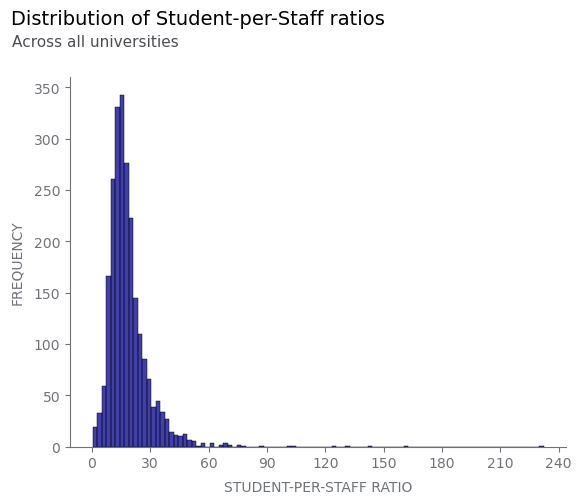

In [31]:
fig, ax = plt.subplots()
sns.histplot(data = df, x = 'n_student_per_staff', bins = 100, ax = ax, color = 'darkblue')
sns.despine(right = True)

ax.set_xticks(range(0, 250, 30))
ax.set_title('Distribution of Student-per-Staff ratios', pad = 38, x = -0.12, ha = 'left', size = 14)
ax.text(s = 'Across all universities', x = -41, y = 390, color = '#4C4E52', size = 11)
ax.set_xlabel('STUDENT-PER-STAFF RATIO', color = '#6F7378', labelpad = 7)
ax.set_xticklabels(ax.get_xticklabels(), color = '#6F7378')
ax.set_ylabel('FREQUENCY', color = '#6F7378', labelpad = 7)
ax.set_yticklabels(ax.get_yticklabels(), color = '#6F7378')
ax.tick_params(color = '#6F7378')

for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

plt.show()

The typical student-per-staff ratio is around 10-25, but a few universities have a ratio of over 60. Let's explore these universities more closely.

In [32]:
less_staff = df[df['n_student_per_staff'] > 60].sort_values('n_student_per_staff', ascending = False)
less_staff

,rank,university_name,location,n_student,n_student_per_staff,international_student_prop,female_prop,male_prop,location_iso3
1164,1001–1200,University of South Africa,South Africa,236282,232.2,3.0,73.0,27.0,ZAF
1971,Reporter,University of Franca,Brazil,50760,160.6,0.0,57.0,43.0,BRA
1942,Reporter,EAN University,Colombia,10000,142.9,0.0,NaN,NaN,COL
1997,Reporter,University of the Highlands and Islands,United Kingdom,7200,130.9,12.0,61.0,39.0,GBR
1713,1501+,Payame Noor University,Iran,454155,124.7,1.0,60.0,40.0,IRN
1845,Reporter,Arab Open University – Kuwait,Kuwait,9139,103.9,64.0,57.0,43.0,KWT
566,501–600,Open University of Catalonia,Spain,32319,100.5,6.0,57.0,43.0,ESP
1205,1201–1500,Abdelmalek Essaâdi University,Morocco,112677,88.2,1.0,50.0,50.0,MAR
1097,1001–1200,Kwame Nkrumah University of Science and Techno...,Ghana,87443,78.1,1.0,43.0,57.0,GHA
2006,Reporter,Ignatius Ajuru University of Education,Nigeria,29785,75.2,0.0,49.0,51.0,NGA


21 universities have student-per-staff ratios over 60, which is concerning especially those with the student-per-staff ratios that exceed 100. Let's take a closer look at these universities which have more than 100 student-per-staff ratios.

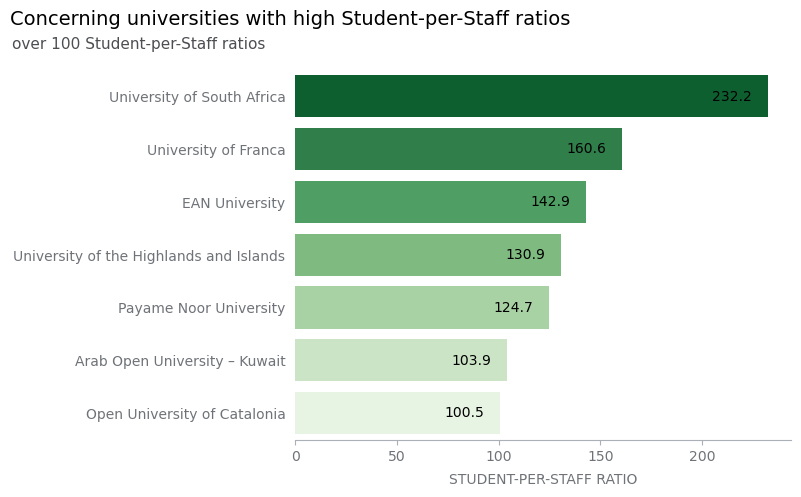

In [33]:
fig, ax = plt.subplots()

sns.barplot(ax = ax, data = less_staff[less_staff['n_student_per_staff'] > 100], 
            x = 'n_student_per_staff', y = 'university_name', palette = 'Greens_r')
sns.despine(right = True, left = True)

ax.bar_label(ax.containers[0], padding = -40, color = 'black')

ax.set_xlabel('STUDENT-PER-STAFF RATIO', color = '#6F7378', labelpad = 7)
ax.set_ylabel('')
ax.set_yticklabels(ax.get_yticklabels(), color = '#6F7378')
ax.set_xticklabels(ax.get_xticklabels(), color = '#6F7378')
ax.tick_params(left = False, color = '#ABB0B8')
for spine in ax.spines.values():
    spine.set_edgecolor("#ABB0B8")
    
ax.set_title('Concerning universities with high Student-per-Staff ratios', x = -0.01, y = 1.1, size = 14)
ax.text(s = 'over 100 Student-per-Staff ratios', x = -139, y = -0.9, color = '#4C4E52', size = 11)

plt.show()

The most concerning finding of this plot is that the University of South Africa has a student-per-staff ratio of over 200, although all of these universities raise similar concerns. This raises two questions:

1. Are these universities popular with international students?
2. What about rankings? Does any of them have a decent university rank despite their high student-per-staff ratios?

Let's try to answer the first question by looking at the entire subset of universities with more than 60 student-per-staff ratio.

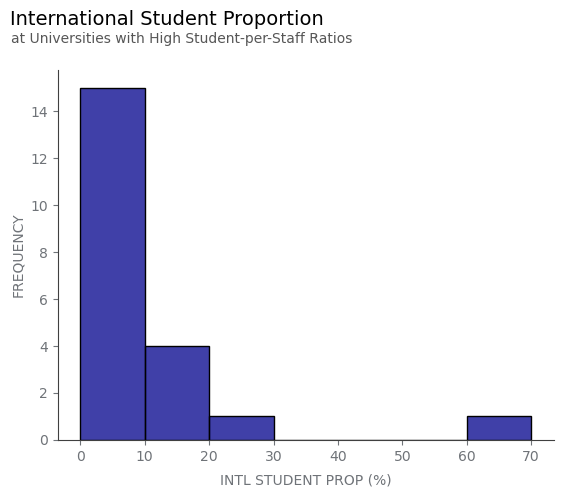

In [34]:
fig, ax = plt.subplots()

sns.histplot(x = 'international_student_prop', data = less_staff, 
             binwidth = 10, color = 'darkblue', ax = ax)
sns.despine(right = True)

ax.tick_params(color = '#6F7378')
ax.set_ylabel('FREQUENCY', color = '#6F7378')
ax.set_yticklabels(ax.get_yticklabels(), color = '#6F7378')
ax.set_xlabel('INTL STUDENT PROP (%)', color = '#6F7378', labelpad = 7)
ax.set_xticklabels(ax.get_xticklabels(), color = '#6F7378') 

for spine in ax.spines.values():
    spine.set_edgecolor("#404040")

ax.set_title('International Student Proportion', x = 0.22, y = 1.1, size = 14)
ax.text(s = 'at Universities with High Student-per-Staff Ratios', color = '#565656',
        x = -10.7, y = 16.9, size = 10)

plt.show()

Most universities with a student-per-staff ratio over 60 have a low proportion of international students (around 0-10%), suggesting that they are intended for local students and are less visible to international students. The exception is the Arab Open University - Kuwait, which has a 60-70% international student proportion.

This raises an important question for future analysis with more relevant data: 

**"Why do universities that are mostly filled with local students have such concerning student-per-staff ratios (more than 60 student per staff)? This could lead to less support and a worse study experience for students."**

Answering this question accurately requires more relevant data, such as university resources and staffing, which is certainly classified! Therefore, let's move on to the second question.

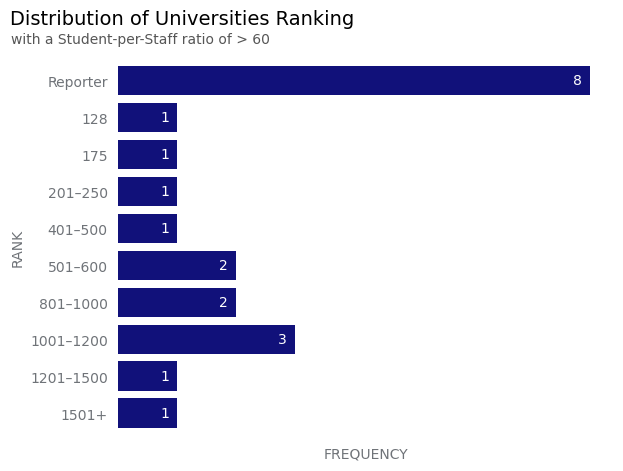

In [35]:
# Making the rank ordered
less_staff['rank'] = pd.Categorical(less_staff['rank'], categories = ['Reporter', '128', '175', '201–250',
                                                                      '401–500', '501–600', '801–1000',
                                                                      '1001–1200', '1201–1500', '1501+'],
                                    ordered = True)

# Horizontal bar plot
fig, ax = plt.subplots()
sns.countplot(y = 'rank', data = less_staff, color = 'darkblue', ax = ax)
sns.despine(right = True, left = True, bottom = True)

ax.bar_label(ax.containers[0], padding = -12, color = 'white')

ax.tick_params(left = False, bottom = False)
ax.set_xlabel('FREQUENCY', color = '#6F7378')
ax.set_xticklabels([])
ax.set_ylabel('RANK', color = '#6F7378')
ax.set_yticklabels(ax.get_yticklabels(), color = '#6F7378')
ax.set_title('Distribution of Universities Ranking', size = 14, x = 0.13, y = 1.08)
ax.text(s = 'with a Student-per-Staff ratio of > 60', x = -1.8, y = -1, color = '#565656', size = 10)

plt.show()

Most universities with a student-per-staff ratio over 60 are ranked and evenly distributed across all rank brackets. However, a few have surprisingly high ranks, such as the University of Hamburg (128) and Macquarie University (175). This suggests that these universities have other factors contributing to their ranking despite their high student-per-staff ratios. Eight universities are yet to be ranked.

# Summary and Closing

Alas, what a lengthy and fun journey that was. We find countless of insights in this dataset, but we need to stick to our track! That is:
1. Which universities are most popular with international students?
    - What can we learn about the student-per-staff ratios at these universities? Are there any universities where there are a lot more students than staff, or vice versa?
    - Are there any universities that are a more popular choice for a particular gender?
2. What does the student-per-staff ratio mean and how can it affect students, staff, and universities?
    - Are there any universities with a concerning student-per-staff ratios?
    
**POPULAR UNIVERSITY CHOICES FOR INTERNATIONAL STUDENTS**

We assumed that universities that have more than 50% international student proportion to be a popular choice for international students. According to this dataset, the popular university for international students are mainly located in the United Kingdom, with a total of 16 universities. We found these universities are the mostly populated with international students regardless of their ranks (sorted descendingly by international student proportion):

*Note: IS = International Students*

1. Paris University of International Education (100% IS)
    - Rank: Reporter 
    - Student-per-staff ratio: 30
    - Popular for male students (68%)
    - Location: Paris, France
    - Subjects taught: Business & Economics, Education
    - More information: https://puie.ac/
    
2. César Ritz Colleges Switzerland (99% IS)
    - Rank: Reporter
    - Student-per-staff ratio: 5
    - Popular for both male and female students
    - Location: Le Bouveret, Switzerland
    - Subjects taught: Business & Economics (Hospitality)
    - More information: https://www.cesarritzcolleges.edu/en/
    
3. Macau University of Science and Technology (91% IS)
    - Rank: 201-250
    - Student-per-staff ratio: 38
    - Popular for female students (57%)
    - Location: Taipa, Macau
    - Subjects taught: Social Sciences, Sciences, Law, Management, Business, Medicine, Pharmacy, Tourism, Art, Communication, and Languages.
    - More information: https://www.must.edu.mo/en
    
4. London Business School (91% IS)
    - Rank: Reporter
    - Student-per-staff ratio: 18
    - Popular for male students (62%)
    - Location: London, United Kingdom
    - Subjects taught: Accounting, Economics, Finance, Management Science and Operations, Marketing, Organizational Behavior, Strategy and Entrepreneurship.
    - More information: https://www.london.edu/

5. Constructor University Brumen (84% IS)
    - Rank: 501-600
    - Student-per-staff ratio: 22
    - Popular for male students (57%)
    - Location: Bremen, Germany
    - Subjects taught: Business & Economics, Computer Science, Engineering & Technology, Life Sciences, Physical Sciences, Psychology, Life Sciences
    - More information: https://constructor.university/
    
6. Near East University (83% IS)
    - Rank: 601-800
    - Student-per-staff ratio: 24
    - Popular for male students (57%)
    - Location: Yakın Doğu Bulvarı Lefkoşa, Northern Cyprus
    - Subjects taught: Arts & Humanities, Business & Economics, Clinical/Pre-clinical & Health, Computer Science, Education, Engineering & Technology, Law, Life Sciences, Physical Sciences, Psychology, Social Sciences
    - More information: https://neu.edu.tr/?lang=en

7. Central European University (83% IS)
    - Rank: Reporter
    - Student-per-staff ratio: 8
    - Popular for female students (55%)
    - Location: Vienna, Austria
    - Subjects taught: Arts & Humanities, Business and Management, Engineering and Technology, Life Sciences and Medicine, Natural Sciences, Social Sciences and Management
    - More information: https://www.ceu.edu/

8. Ajman University (82% IS)
    - Rank: Reporter
    - Student-per-staff ratio: 16
    - Popular for female students (59%)
    - Location: Ajman, United Arab Emirates
    - Subjects taught: Arts & Humanities, Business & Economics, Clinical/Pre-clinical & Health, Computer Science, Education, Engineering & Technology, Law, Psychology, Social Sciences
    - More information: https://www.ajman.ac.ae/en

9. Anglo-American University (80% IS)
    - Rank: Reporter
    - Student-per-staff ratio: 13
    - Popular for male students (60%)
    - Location: Prague, Czech Republic
    - Subjects taught: Arts & Humanities, Business & Economics, Social Sciences
    - More information: https://www.aauni.edu/

10. Royal College of Art (77% IS)
    - Rank: Reporter
    - Student-per-staff ratio: 21
    - Popular for female students (69%)
    - Location: London, United Kingdom
    - Subjects taught: Art, Architecture, Applied Art, Design, Communications and Humanities
    - More information: https://www.rca.ac.uk/

If you care about university rankings but looking for universities that are still popular with international students. Here are some recommended universities you can try (sorted ascending by rank):

1. Imperial College London (61% IS)
    - Rank: 10th
    - Student-per-staff ratio: 11
    - Popular for male students (60%)
    - Location: London, United Kingdom
    - Subjects taught: Clinical/Pre-clinical & Health, Computer Science, Engineering & Technology, Life Sciences, Physical Sciences
    - More information: https://www.imperial.ac.uk/
    
2. UCL (60% IS)
    - Rank: 22th
    - Student-per-staff ratio: 10
    - Popular for female students (59%)
    - Location: London, United Kingdom
    - Subjects taught: Arts & Humanities, Business & Economics, Clinical/Pre-clinical & Health, Computer Science, Education, Engineering & Technology, Law, Life Sciences, Psychology, Physical Sciences, Social Sciences
    - More information: https://www.ucl.ac.uk/
     
3. King's College London (52% IS)
    - Rank: 35th
    - Student-per-staff ratio: 12
    - Popular for female students (63%)
    - Location: London, United Kingdom
    - Subjects taught: Arts & Humanities, Business & Economics, Clinical/Pre-clinical & Health, Computer Science, Education, Engineering & Technology, Law, Life Sciences, Psychology, Physical Sciences, Social Sciences
    - More information: https://www.kcl.ac.uk/
    
4. London School of Economics and Political Science (73% IS)
    - Rank: 37th
    - Student-per-staff ratio: 12
    - Popular for female students (55%)
    - Location: London, United Kingdom
    - Subjects taught: Arts & Humanities, Business & Economics, Law, Psychology, Physical Sciences, Social Sciences
    - More information: https://www.lse.ac.uk/
    
5. École Polytechnique Fédérale de Lausanne (62% IS)
    - Rank: 41st
    - Student-per-staff ratio: 12
    - Popular for male students (70%)
    - Location: Lausanne, Switzerland
    - Subjects taught: Arts & Humanities, Business & Economics, Computer Science, Engineering & Technology, Life Sciences, Physical Sciences
    - More information: https://www.epfl.ch/
    
6. Australian National University (51% IS)
    - Rank: 62nd
    - Student-per-staff ratio: 15
    - Popular for both male and female students
    - Location: Canberra, Australia
    - Subjects taught: Arts & Humanities, Business & Economics, Clinical/Pre-clinical & Health, Computer Science, Engineering & Technology, Law, Life Sciences, Psychology, Physical Sciences, Social Sciences
    - More information: https://www.anu.edu.au/
    
7. City University of Hong Kong (62% IS)
    - Rank: 99th
    - Student-per-staff ratio: 12
    - Popular for female students (54%)
    - Location: Kowloon, Hong Kong
    - Subjects taught: Arts & Humanities, Business & Economics, Computer Science, Engineering & Technology, Law, Life Sciences, Psychology, Physical Sciences, Social Sciences
    - More information: https://www.rca.ac.uk/
    
8. Maastricht University (56% IS)
    - Rank: 145th
    - Student-per-staff ratio: 19
    - Popular for female students (60%)
    - Location: Maastricht, Netherlands
    - Subjects taught: Arts & Humanities, Business & Economics, Clinical/Pre-clinical & Health, Computer Science, Education, Engineering & Technology, Law, Life Sciences, Psychology, Physical Sciences, Social Sciences
    - More information: https://www.maastrichtuniversity.nl/
    
9. University of Luxembourg (51% IS)
    - Rank: 201-250th
    - Student-per-staff ratio: 19
    - Popular for both male and female students
    - Location: Esch-sur-Alzette, Luxembourg
    - Subjects taught: Arts & Humanities, Business & Economics, Clinical/Pre-clinical & Health, Computer Science, Education, Engineering & Technology, Law, Life Sciences, Psychology, Physical Sciences, Social Sciences
    - More information: https://www.uni.lu/en/
    
10. Macau University of Science and Technology
    - Rank: 201-250
    - Student-per-staff ratio: 38
    - Popular for female students (57%)
    - Location: Taipa, Macau
    - Subjects taught: Social Sciences, Sciences, Law, Management, Business, Medicine, Pharmacy, Tourism, Art, Communication, and Languages.
    - More information: https://www.must.edu.mo/en
    
    
**CONCERNING STUDENT-PER-STAFF RATIO**

A good university will provide its students with the best learning experience and a balanced workload for staff. However, there are both pros and cons to having more students than staff or more staff than students.

Having more students than staff:
- Pros: Lower overhead costs and increased revenue
- Cons: Students may not receive the best learning support, staff may burn out and perform poorly

Having more staff than students:
- Pros: Students will receive more learning support, staff will be more aware of their students' conditions
- Cons: Higher overhead costs, universities may struggle to allocate staff resources effectively

It is important to note that the student-per-staff ratio does not tell the whole story. Many other factors contribute to a student's experience at a university, such as the type of university, the amount of time staff members spend with students, and the availability of resources. A student-per-staff ratio of over 20 is generally considered challenging for university staff to provide good learning support.

Most universities in this dataset have a student-per-staff ratio of 10-25, but 21 universities have a concerning ratio of over 60, with some as high as over 100. These universities include:

1. University of South Africa (232)
2. University of Franca (160)
3. EAN University (143)
4. University of the Highlands and Islands (131)
5. Payame Noor University (125)
6. Arab Open University - Kuwait (104)
7. Open University of Catalonia (101)

Most universities with a student-to-staff ratio over 60 have a low proportion of international students, suggesting that they are intended for local students and are less visible to international students. However, the Arab Open University - Kuwait is an exception, with a 60-70% international student proportion.

This raises an important question for future analysis: "Why do universities that are mostly filled with local students have such concerning student-to-staff ratios?". This could lead to less support and a worse study experience for students. However, answering this question accurately requires more relevant data, such as university resources and staffing, which is not publicly available.

Most universities with a high student-per-staff ratio are ranked across all rank brackets, but a few have surprisingly high ranks. This suggests that these universities have other factors contributing to their ranking, despite their high student-per-staff ratios. Eight universities with high student-per-staff ratios are yet to be ranked.